In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import os
import sys

parent = os.path.dirname(os.getcwd())  # workaround to import from utils/
sys.path.append(parent)

from utils.db_utils import df_from_snowflake
from utils.bayes import Bayesian_AB
pd.option_context('display.max_rows', None,)
pp.style.use('ggplot')

In [2]:
with open ('sql_template/revenue.sql', 'r') as sql_file:
    df = df_from_snowflake(sql_file.read())
df.set_index('DT', inplace=True)

In [3]:
df

,ID,USERS,SESSIONS,REVENUES,ONSITE_BOOKINGS,SEARCHES,UWOB,CUM_USERS,CUM_REVENUES,CUM_ONSITE_BOOKINGS,CUM_UWOB,RPU,ONSITE_BOOKING_PER_USER
DT,,,,,,,,,,,,,
2024-02-27,e3887v0,4256,4678,1849.517531,6.0000000000,12493,6,4256,1849.517531,6.0000000000,6,0.434567,0.001409774436
2024-02-27,e3887v1,4197,4592,1644.439443,8.0000000000,12246,8,4197,1644.439443,8.0000000000,8,0.391813,0.001906123421
2024-02-28,e3887v0,10649,12668,4226.888245,11.0000000000,30084,10,14905,6076.405775,17.0000000000,16,0.407676,0.001140556860
2024-02-28,e3887v1,10666,12781,4616.071598,20.0000000000,31007,19,14863,6260.511041,28.0000000000,27,0.421214,0.001883872704
2024-02-29,e3887v0,9756,11649,3084.189859,7.0000000000,29503,7,24661,9160.595634,24.0000000000,23,0.371461,0.000973196545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-06,e3887v1,16591,19894,4857.307096,21.0000000000,49463,21,1612562,567355.604454,2770.0000000000,2705,0.351835,0.001717763410
2024-06-07,e3887v0,14981,17755,2907.321839,12.0000000000,44201,12,1616742,543422.829281,2521.0000000000,2473,0.336122,0.001559308783
2024-06-07,e3887v1,15013,17970,2186.766238,18.0000000000,43771,18,1627575,569542.370692,2788.0000000000,2723,0.349933,0.001712977897


In [4]:
df.drop(df[df['USERS']=='e3887v0'].index, inplace=True)

In [5]:
control = df.loc[df['ID']=='e3887v0',['USERS','ONSITE_BOOKINGS']]
treatment = df.loc[df['ID']=='e3887v1',['USERS','ONSITE_BOOKINGS']]

In [6]:
E = Bayesian_AB(project_name='e3887-mobile',
                date_column='DT',
                sample_column='USERS',
                conversion_column='ONSITE_BOOKINGS',
                alpha_prior=1, 
                beta_prior=1,
                day_index=True,
                simulations= 1
            )

In [7]:
simulation_ImSa = E.posterior_analytic_importance_sampling(control=control,
                                                           variant=treatment)
simulation_ImSa

,simulations,day,variant_expected_loss,control_expected_loss,prob_variant_better_than_control,prob_variant_better_control_error,control_cvr,control_cvr_lower,control_cvr_upper,variant_cvr,variant_cvr_lower,variant_cvr_upper
0,1,0,1.722157e-04,0.000674,0.705946,0.000945,0.001644,0.000661,0.003065,0.002143,0.000981,0.003751
1,1,1,9.731353e-06,0.000755,0.951103,0.000714,0.001207,0.000716,0.001825,0.001951,0.001307,0.002721
2,1,2,1.189409e-06,0.000771,0.989723,0.000622,0.001014,0.000656,0.001448,0.001783,0.001296,0.002346
3,1,3,1.509046e-05,0.000381,0.892714,0.000754,0.001251,0.000898,0.001661,0.001617,0.001212,0.002080
4,1,4,8.433905e-05,0.000127,0.564506,0.000835,0.001595,0.001254,0.001975,0.001637,0.001292,0.002022
...,...,...,...,...,...,...,...,...,...,...,...,...
98,1,98,3.064434e-09,0.000158,0.999005,0.000548,0.001569,0.001508,0.001632,0.001727,0.001663,0.001793
99,1,99,4.823448e-09,0.000153,1.000835,0.000547,0.001571,0.001510,0.001633,0.001723,0.001659,0.001788
100,1,100,4.604781e-09,0.000151,0.999395,0.000546,0.001567,0.001506,0.001629,0.001718,0.001655,0.001783
101,1,101,3.353946e-09,0.000154,0.998931,0.000547,0.001560,0.001500,0.001621,0.001714,0.001651,0.001778


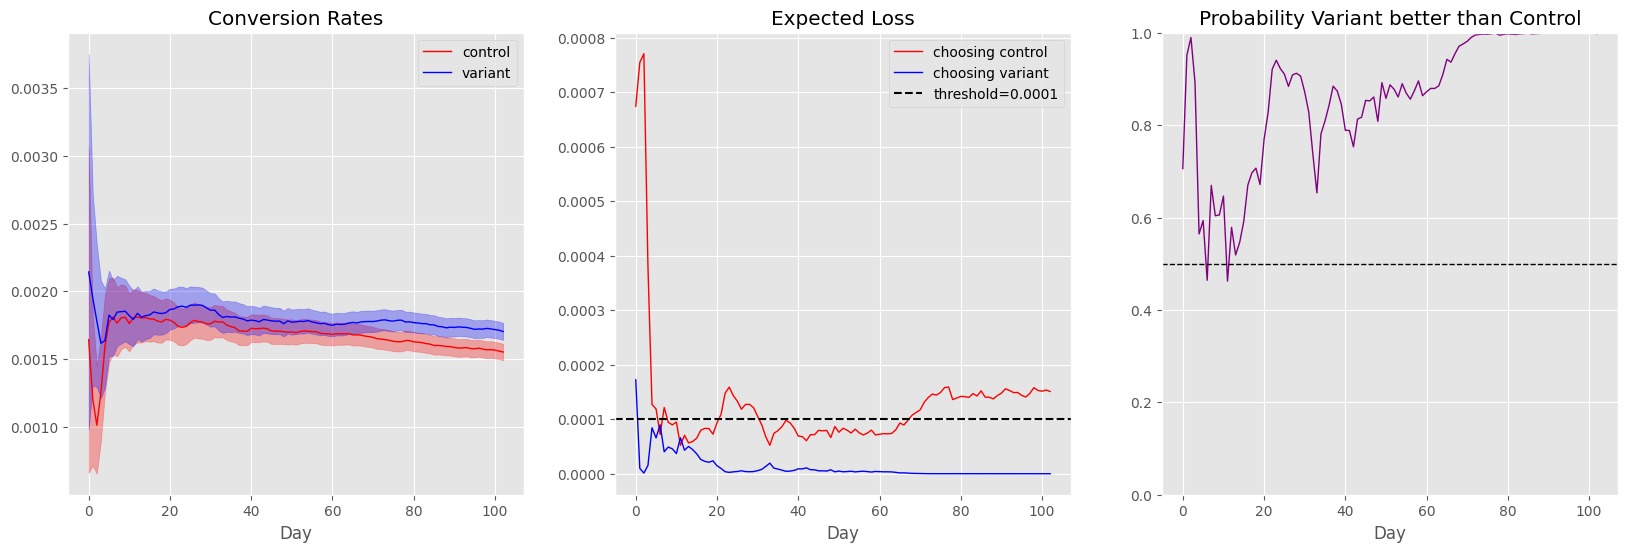

In [8]:
E.plot_expected_loss(simulation_ImSa)

In [9]:
E.get_results()

VALUE
GROUP   METRIC                                       
control CvR                                   0.00155
        95% credible interval      (0.00149, 0.00161)
variant CvR                                   0.00170
        95% credible interval      (0.00164, 0.00177)
outcome uplift                                 9.735%
        control expected loss                0.000151
        variant expected loss                     0.0
        prob (variant >= control)             99.822%
        standard error                       0.000548

### SUBSCRIPTION

In [2]:
with open ('sql_template/subscription_rate.sql', 'r') as sql_file:
    crm = df_from_snowflake(sql_file.read())
    
crm.sort_values(by='DT', ignore_index=True, inplace=True)
crm.set_index('DT', inplace=True)

In [4]:
control_2 = crm.loc[crm['ID']=='e3887v0',['COOKIE_USER_IDS','SUBSCRIBERS']]
treatment_2 = crm.loc[crm['ID']=='e3887v1',['COOKIE_USER_IDS','SUBSCRIBERS']]

In [5]:
E = Bayesian_AB(project_name='e3887-mobile',
                date_column='DT',
                sample_column='COOKIE_USER_IDS',
                conversion_column='SUBSCRIBERS',
                alpha_prior=1, 
                beta_prior=1,
                day_index=True,
                simulations= 1
            )
simulation_2 = E.posterior_analytic_importance_sampling(control=control_2,
                                                           variant=treatment_2)
simulation_2

,simulations,day,variant_expected_loss,control_expected_loss,prob_variant_better_than_control,prob_variant_better_control_error,control_cvr,control_cvr_lower,control_cvr_upper,variant_cvr,variant_cvr_lower,variant_cvr_upper
0,1,0,0.000942,9.794741e-04,5.057452e-01,8.162541e-04,0.013675,0.010549,0.017194,0.013714,0.010556,0.017272
1,1,1,0.001903,3.770326e-05,6.815506e-02,2.925132e-04,0.014757,0.013016,0.016603,0.012892,0.011269,0.014622
2,1,2,0.002963,3.366691e-07,1.226277e-03,2.200526e-05,0.015588,0.014194,0.017045,0.012621,0.011372,0.013934
3,1,3,0.002196,1.317158e-06,4.915165e-03,5.455410e-05,0.015333,0.014134,0.016580,0.013137,0.012029,0.014292
4,1,4,0.001870,1.072823e-06,4.785007e-03,5.348906e-05,0.015531,0.014518,0.016576,0.013663,0.012714,0.014644
...,...,...,...,...,...,...,...,...,...,...,...,...
98,1,98,0.000780,0.000000e+00,0.000000e+00,0.000000e+00,0.017300,0.017113,0.017487,0.016521,0.016339,0.016703
99,1,99,0.000803,0.000000e+00,0.000000e+00,0.000000e+00,0.017318,0.017133,0.017505,0.016516,0.016335,0.016697
100,1,100,0.000814,6.762839e-14,1.239176e-09,1.239174e-09,0.017343,0.017159,0.017529,0.016529,0.016350,0.016710
101,1,101,0.000833,0.000000e+00,0.000000e+00,0.000000e+00,0.017366,0.017182,0.017551,0.016533,0.016355,0.016713


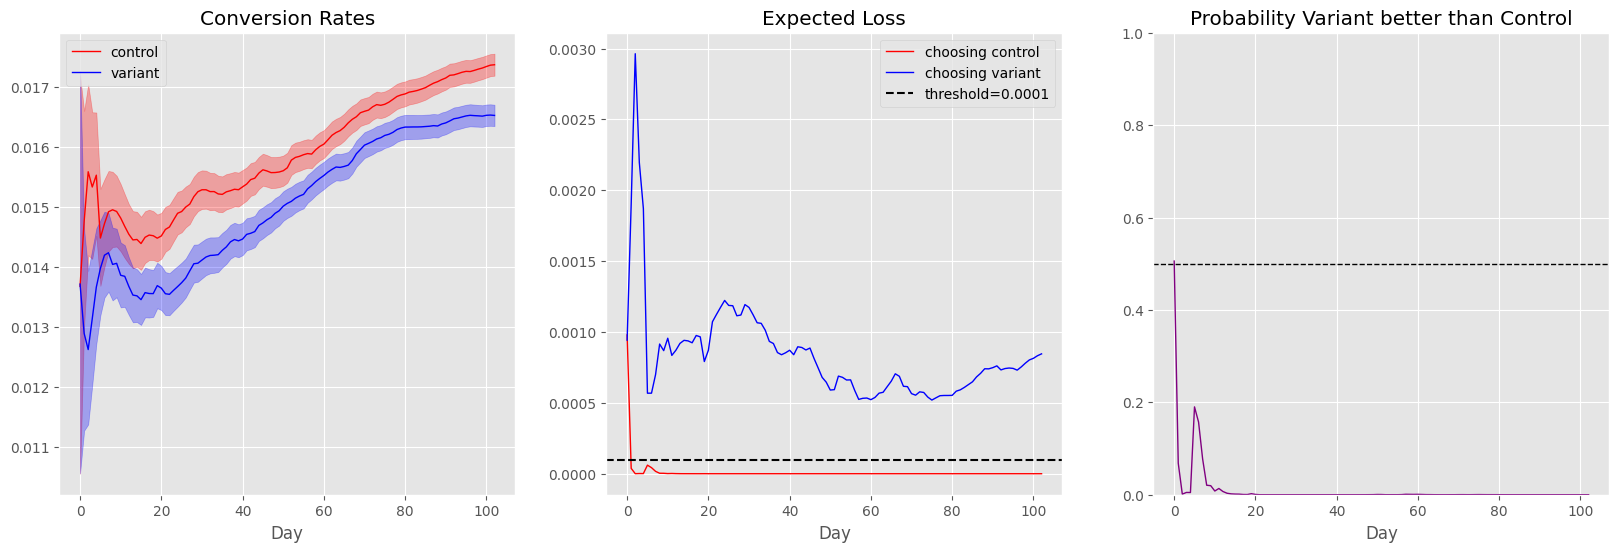

In [6]:
E.plot_expected_loss(simulation_2)

In [7]:
E.get_results()

VALUE
GROUP   METRIC                                       
control CvR                                   0.01737
        95% credible interval      (0.01719, 0.01756)
variant CvR                                   0.01653
        95% credible interval      (0.01635, 0.01671)
outcome uplift                                -4.867%
        control expected loss                     0.0
        variant expected loss                0.000846
        prob (variant >= control)              0.000%
        standard error                            0.0